# Lending Club Loan Dataset

This notebook aims to predict which loans will be either “Fully paid” or “Charged off”, taking Lending Club data from 2018. The dataset contains both numerical and categorical data gathered before and after loans are extended, so there is a need identify which features are determined after the fact. Categorical data is encoded into numerical values, and rows with outliers are discarded as well as features with constant, or missing values over 30%. Remaining missing values are replaced with the median of the corresponding feature. After this, the dataset is split into training and test sets. Training set is rebalanced, generating synthetic samples with the SMOTE algorithm, and then a data scaling is performed. PCA is applied with a Random Forest with default hyperparameters, giving 25 principal components, which then are used for running a series of default classifiers for finding the best one, finding that Extra Trees Classifier gives the best results, which is later optimized with RandomizedSearch with 3 Cross-validations for hyperparameter tuning. Final accuracy is 0.9036, but other evaluation criteria are poor. This could be improved with more extensive iterations of RandomizedSearchCV.

The 10 most important features for this classification exercise, according to the default Random Forest Classifier are:
* Loan grade
* Verification status
* Loan sub-grade
* Loan Term
* Number of credit inquiries in past 6 months
* Interest Rate on the loan
* Number of open trades in last 6 months
* Purpose for the loan provided by the borrower.
* Employment length in years
* Number of revolving trades opened in past 24 months

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats
%matplotlib inline
from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
#
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#from sklearn import svm
from sklearn import metrics

#
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
#
from sklearn.metrics import classification_report,confusion_matrix
#
## Oversampling 
from imblearn.over_sampling import SMOTE
#
##scaling
from sklearn.preprocessing import StandardScaler
#
##Preprocessing
from sklearn import preprocessing
from sklearn.decomposition import PCA
#
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
#
##Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection

In [163]:
# Data import
location1 = 'D:\DATA\Loan Data\LoanStats_2018Q1.csv'

df_loanq1 = pd.read_csv(location1, header=1)

df_loanq1.head()

c:\program files\python36\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,35000.0,35000.0,35000.0,60 months,13.58%,806.79,C,C2,Security Officer,7 years,MORTGAGE,160000.0,Source Verified,Mar-2018,Current,n,NaN,NaN,home_improvement,Home improvement,207xx,MD,7.87,0.0,Dec-2005,1.0,NaN,97.0,14.0,1.0,10333.0,24.5%,24.0,w,28807.40,28807.40,11242.25,11242.25,6192.60,5049.65,0.0,0.0,0.0,Jun-2019,806.79,Jul-2019,Jun-2019,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,38964.0,3.0,1.0,1.0,1.0,3.0,28631.0,99.0,4.0,6.0,2674.0,55.0,42200.0,3.0,3.0,4.0,7.0,2783.0,12723.0,38.2,0.0,0.0,128.0,147.0,2.0,2.0,0.0,12.0,NaN,0.0,NaN,0.0,5.0,10.0,5.0,10.0,6.0,13.0,18.0,10.0,14.0,0.0,0.0,0.0,5.0,100.0,0.0,1.0,0.0,71160.0,38964.0,20600.0,28960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,24000.0,24000.0,24000.0,36 months,21.85%,914.71,D,D5,NaN,NaN,RENT,53000.0,Not Verified,Mar-2018,Current,n,NaN,NaN,credit_card,Credit card refinancing,398xx,GA,28.67,0.0,Dec-2000,0.0,NaN,NaN,7.0,0.0,23692.0,73.6%,11.0,w,16459.87,16459.87,12747.67,12747.67,7540.13,5207.54,0.0,0.0,0.0,May-2019,914.71,Jul-2019,Jun-2019,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,43436.0,0.0,1.0,0.0,0.0,32.0,19744.0,63.0,0.0,1.0,7089.0,69.0,32200.0,0.0,0.0,1.0,1.0,6205.0,1408.0,89.7,0.0,0.0,79.0,207.0,13.0,13.0,0.0,32.0,NaN,12.0,NaN,0.0,3.0,5.0,3.0,3.0,4.0,6.0,7.0,5.0,7.0,0.0,0.0,0.0,0.0,100.0,66.7,0.0,0.0,63411.0,43436.0,13700.0,31211.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2500.0,2500.0,2500.0,36 months,6.71%,76.87,A,A3,Facility manager,10+ years,MORTGAGE,53700.0,Source Verified,Mar-2018,Current,n,NaN,NaN,other,Other,166xx,PA,2

In [164]:
# Data import
location2 = 'D:\DATA\Loan Data\LoanStats_securev1_2018Q2.csv'

df_loanq2 = pd.read_csv(location2, header=1)

df_loanq2.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,135788850,NaN,24000.0,24000.0,24000.0,36 months,6.83%,739.19,A,A3,Adjuster,8 years,RENT,62000.0,Source Verified,Jun-2018,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,060xx,CT,36.76,0.0,Jul-2005,775.0,779.0,1.0,NaN,NaN,16.0,0.0,11321.0,26.8%,40.0,w,0.00,0.00,24465.216104,24465.22,24000.00,428.26,36.96,0.0,0.0,Oct-2018,22913.66,NaN,Jun-2019,774.0,770.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,70756.0,2.0,4.0,1.0,1.0,6.0,59435.0,67.0,1.0,3.0,11134.0,49.0,42300.0,6.0,14.0,7.0,4.0,4422.0,19856.0,35.9,0.0,0.0,110.0,155.0,5.0,5.0,0.0,13.0,NaN,0.0,NaN,0.0,2.0,3.0,6.0,8.0,19.0,12.0,21.0,3.0,16.0,0.0,0.0,0.0,2.0,100.0,16.7,0.0,0.0,129493.0,70756.0,31000.0,87193.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,136055010,NaN,20000.0,20000.0,20000.0,60 months,26.77%,607.97,E,E5,HRSS,10+ years,MORTGAGE,65000.0,Source Verified,Jun-2018,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,301xx,GA,35.41,0.0,Mar-2003,670.0,674.0,0.0,NaN,82.0,8.0,1.0,13796.0,77.5%,22.0,w,18008.47,18008.47,6628.180000,6628.18,1991.53,4636.65,0.00,0.0,0.0,May-2019,607.97,Jul-2019,Jun-2019,664.0,660.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,45906.0,0.0,3.0,0.0,0.0,32.0,32110.0,44.0,0.0,0.0,5142.0,51.0,17800.0,0.0,0.0,0.0,0.0,5738.0,1079.0,92.2,0.0,0.0,131.0,183.0,33.0,32.0,2.0,33.0,NaN,21.0,NaN,0.0,3.0,4.0,3.0,7.0,5.0,5.0,15.0,4.0,8.0,0.0,0.0,0.0,0.0,100.0,100.0,1.0,0.0,90868.0,45906.0,13900.0,73068.0,NaN

In [165]:
# Data import
location3 = 'D:\DATA\Loan Data\LoanStats_securev1_2018Q3.csv'

df_loanq3 = pd.read_csv(location3, header=1)

df_loanq3.head()

c:\program files\python36\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,129,130,131,134,135,136,139) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,141124209,NaN,25000.0,25000.0,25000.0,36 months,16.14%,880.66,C,C4,Business Planner,10+ years,RENT,82000.0,Source Verified,Sep-2018,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,940xx,CA,19.60,0.0,Mar-1994,695.0,699.0,1.0,NaN,NaN,10.0,0.0,15437.0,59.4%,17.0,w,19828.26,19828.26,7881.110000,7881.11,5171.74,2709.37,0.0,0.0,0.0,Jun-2019,880.66,Jul-2019,Jun-2019,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,39316.0,2.0,2.0,1.0,1.0,4.0,23879.0,59.0,4.0,5.0,5932.0,59.0,26000.0,0.0,0.0,1.0,6.0,3932.0,1844.0,87.7,0.0,0.0,127.0,294.0,1.0,1.0,0.0,1.0,NaN,1.0,NaN,0.0,4.0,6.0,4.0,4.0,5.0,8.0,12.0,6.0,10.0,0.0,0.0,0.0,5.0,94.1,75.0,0.0,0.0,66646.0,39316.0,15000.0,40646.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,141097380,NaN,20000.0,20000.0,20000.0,36 months,7.84%,625.26,A,A4,Teacher,10+ years,MORTGAGE,48186.0,Not Verified,Sep-2018,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,641xx,MO,24.68,0.0,Aug-1996,720.0,724.0,0.0,NaN,NaN,17.0,0.0,23822.0,58.8%,38.0,w,0.00,0.00,20784.182581,20784.18,20000.00,784.18,0.0,0.0,0.0,Apr-2019,17105.26,NaN,Apr-2019,729.0,725.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,191246.0,0.0,9.0,0.0,2.0,16.0,14800.0,48.0,1.0,1.0,11800.0,54.0,40500.0,1.0,0.0,0.0,3.0,11250.0,13078.0,57.8,0.0,0.0,265.0,239.0,8.0,8.0,2.0,8.0,NaN,16.0,NaN,0.0,3.0,4.0,6.0,7.0,27.0,7.0,9.0,4.0,17.0,0.0,0.0,0.0,1.0,100.0,16.7,0.0,0.0,234182.0,38622.0,31000.0,30832.0,NaN,

In [166]:
# Data import
location4 = 'D:\DATA\Loan Data\LoanStats_securev1_2018Q4.csv'

df_loanq4 = pd.read_csv(location4, header=1)

df_loanq4.head()

c:\program files\python36\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,129,130,131,134,135,136,139,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,145638579,NaN,5000.0,5000.0,5000.0,36 months,17.97%,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,490xx,MI,10.51,0.0,Apr-2011,690.0,694.0,0.0,NaN,NaN,8.0,0.0,4599.0,19.1%,13.0,w,4456.17,4456.17,895.96,895.96,543.83,352.13,0.0,0.0,0.0,Jun-2019,180.69,Jul-2019,Jun-2019,609.0,605.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,110299.0,0.0,1.0,0.0,2.0,14.0,7150.0,72.0,0.0,2.0,0.0,35.0,24100.0,1.0,5.0,0.0,4.0,18383.0,13800.0,0.0,0.0,0.0,87.0,92.0,15.0,14.0,2.0,77.0,NaN,14.0,NaN,0.0,0.0,3.0,3.0,3.0,4.0,6.0,7.0,3.0,8.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,145636697,NaN,25000.0,25000.0,25000.0,60 months,14.47%,587.82,C,C2,teacher,10+ years,OWN,110000.0,Not Verified,Dec-2018,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,117xx,NY,26.43,1.0,Jan-1997,715.0,719.0,0.0,7.0,NaN,23.0,0.0,39053.0,45.7%,49.0,w,23533.24,23533.24,2908.95,2908.95,1466.76,1442.19,0.0,0.0,0.0,May-2019,587.82,Jul-2019,Jun-2019,729.0,725.0,0.0,7.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,95648.0,0.0,3.0,0.0,0.0,35.0,54716.0,23.0,1.0,2.0,8422.0,39.0,85500.0,0.0,1.0,0.0,2.0,4159.0,34837.0,44.5,0.0,0.0,263.0,246.0,10.0,10.0,0.0,48.0,NaN,NaN,NaN,0.0,9.0,13.0,10.0,14.0,21.0,19.0,27.0,13.0,23.0,0.0,0.0,1.0,1.0,98.0,10.0,0.0,0.0,179321.0,95648.0,62800.0,91424.0,NaN,NaN,NaN,NaN,

In [167]:
df = pd.concat([df_loanq1, df_loanq2, df_loanq3, df_loanq4], axis=0, sort=False, join = 'outer') # this will produce NA values for columns not present in the Q1 data

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495250 entries, 0 to 128413
Columns: 150 entries, id to sec_app_fico_range_high
dtypes: float64(112), object(38)
memory usage: 570.5+ MB


In [168]:
lst = [df_loanq1, df_loanq2, df_loanq3, df_loanq4]
del df_loanq1, df_loanq2, df_loanq3, df_loanq4 # dfs still in list
del lst     # memory release now

In [169]:
import gc
gc.collect()

5228

In [170]:
pd.set_option('display.max_columns', None)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,fico_range_low,fico_range_high,last_fico_range_high,last_fico_range_low,sec_app_fico_range_low,sec_app_fico_range_high
0,NaN,NaN,35000.0,35000.0,35000.0,60 months,13.58%,806.79,C,C2,Security Officer,7 years,MORTGAGE,160000.0,Source Verified,Mar-2018,Current,n,NaN,NaN,home_improvement,Home improvement,207xx,MD,7.87,0.0,Dec-2005,1.0,NaN,97.0,14.0,1.0,10333.0,24.5%,24.0,w,28807.40,28807.40,11242.25,11242.25,6192.60,5049.65,0.0,0.0,0.0,Jun-2019,806.79,Jul-2019,Jun-2019,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,38964.0,3.0,1.0,1.0,1.0,3.0,28631.0,99.0,4.0,6.0,2674.0,55.0,42200.0,3.0,3.0,4.0,7.0,2783.0,12723.0,38.2,0.0,0.0,128.0,147.0,2.0,2.0,0.0,12.0,NaN,0.0,NaN,0.0,5.0,10.0,5.0,10.0,6.0,13.0,18.0,10.0,14.0,0.0,0.0,0.0,5.0,100.0,0.0,1.0,0.0,71160.0,38964.0,20600.0,28960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,24000.0,24000.0,24000.0,36 months,21.85%,914.71,D,D5,NaN,NaN,RENT,53000.0,Not Verified,Mar-2018,Current,n,NaN,NaN,credit_card,Credit card refinancing,398xx,GA,28.67,0.0,Dec-2000,0.0,NaN,NaN,7.0,0.0,23692.0,73.6%,11.0,w,16459.87,16459.87,12747.67,12747.67,7540.13,5207.54,0.0,0.0,0.0,May-2019,914.71,Jul-2019,Jun-2019,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,43436.0,0.0,1.0,0.0,0.0,32.0,19744.0,63.0,0.0,1.0,7089.0,69.0,32200.0,0.0,0.0,1.0,1.0,6205.0,1408.0,89.7,0.0,0.0,79.0,207.0,13.0,13.0,0.0,32.0,NaN,12.0,NaN,0.0,3.0,5.0,3.0,3.0,4.0,6.0,7.0,5.0,7.0,0.0,0.0,0.0,0.0,100.0,66.7,0.0,0.0,63411.0,43436.0,13700.0,31211.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,desc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term,fico_range_low,fico_range_high,last_fico_range_high,last_fico_range_low,sec_app_fico_range_low,sec_app_fico_range_high
count,0.0,495242.000000,495242.000000,495242.000000,495242.000000,4.952420e+05,0.0,494110.000000,495242.000000,495242.000000,218590.000000,62984.000000,495242.000000,495242.000000,4.952420e+05,495242.000000,495242.000000,495242.00000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.00000,114833.000000,495242.0,6.898500e+04,68985.000000,495242.000000,4.952420e+05,4.952420e+05,495242.000000,495242.000000,495242.000000,495242.000000,476832.000000,4.952420e+05,414418.000000,495242.000000,495242.000000,4.952420e+05,495113.000000,4.952420e+05,495242.000000,495242.000000,495242.000000,495242.000000,495202.000000,488654.000000,488439.000000,495242.000000,495242.000000,476832.000000,495242.000000,495242.000000,495242.000000,495242.000000,489044.000000,98110.000000,433937.000000,142690.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,482838.0,495242.000000,495242.000000,495242.000000,495240.000000,488646.000000,495242.000000,495242.000000,4.952420e+05,4.952420e+05,4.952420e+05,4.952420e+05,6.898500e+04,68985.000000,68985.000000,68985.000000,67788.000000,68985.000000,68985.000000,68985.000000,68985.000000,22377.000000,685.0,685.000000,685.0,685.000000,550.000000,685.000000,685.000000,1119.000000,1119.000000,1119.000000,387378.000000,387378.000000,387378.000000,387378.000000,52654.000000,52654.000000
mean,NaN,16025.020394,16025.020394,16021.669277,466.609094,8.009399e+04,NaN,19.668887,0.229252,0.442192,36.889771,83.338689,11.491554,0.134514,1.627083e+04,22.624151,10457.586501,10455.63440,6626.757686,6625.160316,5069.781429,1530.176743,0.759868,26.039648,4.621871,2043.907431,0.01768,46.319281,1.0,1.283419e+05,19.357812,0.000052,2.143619e+02,1.439598e+05,0.898078,2.700815,0.672936,1.526753,21.100450,3.532369e+04,68.003902,1.228062,2.623687,5.862635e+03,54.087778,3.834538e+04,1.086802,1.484854,1.937368,4.426622,13709.348688,15057.282179,49.867127,0.006823,1.792829,122.954602,174.638102,15.131693,8.718534,1.336308,25.552897,40.467170,7.488555,37.753115,0

#### What are the total number of loans?
The total number of loans amounts to 495,250.

#### How many columns does the dataset have?
The dataset has 150 columns in total, even though the Q1 data has 144 columns.




In [172]:
pd.set_option('display.max_rows', None)

df.isnull().sum()

id                                            107864
member_id                                     495250
loan_amnt                                          8
funded_amnt                                        8
funded_amnt_inv                                    8
term                                               8
int_rate                                           8
installment                                        8
grade                                              8
sub_grade                                          8
emp_title                                      54667
emp_length                                     41995
home_ownership                                     8
annual_inc                                         8
verification_status                                8
issue_d                                            8
loan_status                                        8
pymnt_plan                                         8
url                                           

#### How may columns contain missing data? What is the count of missing data for each of this column?
All columns have at least 8 NA values, and columns 'member_id' and 'desc' don't have any data. Missing data counts for each column can be seen above.

In [173]:
df.loan_status.value_counts()

Current               395475
Fully Paid             69775
Charged Off            15787
Late (31-120 days)      8905
In Grace Period         3642
Late (16-30 days)       1649
Default                    9
Name: loan_status, dtype: int64

#### How many loans are still current?
Current loans amount to 395,465.

# Exploratory Data Analysis

Creation of Fully-paid & Charge-off dataset.

In [174]:
fp_off_df = df[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off')]

In [175]:
fp_off_df.sample(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,fico_range_low,fico_range_high,last_fico_range_high,last_fico_range_low,sec_app_fico_range_low,sec_app_fico_range_high
79014,137918952,NaN,15000.0,15000.0,15000.0,36 months,19.92%,556.85,D,D3,Independent contractor,1 year,RENT,90000.0,Source Verified,Aug-2018,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,331xx,FL,9.77,0.0,Dec-2007,0.0,NaN,NaN,5.0,0.0,3306.0,38.9%,10.0,w,0.0,0.0,2586.160000,2586.16,307.85,232.40,0.00,2045.91,184.1319,Sep-2018,556.85,NaN,Mar-2019,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,2663.0,31797.0,0.0,3.0,0.0,0.0,26.0,28491.0,80.0,0.0,0.0,1444.0,72.0,8500.0,2.0,1.0,4.0,0.0,6359.0,56.0,96.3,0.0,0.0,128.0,48.0,29.0,26.0,0.0,35.0,NaN,6.0,NaN,0.0,1.0,2.0,1.0,2.0,7.0,2.0,3.0,2.0,5.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,44295.0,31797.0,1500.0,35795.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,660.0,664.0,624.0,620.0,NaN,NaN
82982,NaN,NaN,30000.0,30000.0,30000.0,60 months,26.30%,903.55,E,E5,NaN,NaN,MORTGAGE,89500.0,Verified,Jan-2018,Charged Off,n,NaN,NaN,debt_consolidation,Debt consolidation,956xx,CA,21.19,1.0,May-1986,0.0,14.0,107.0,9.0,1.0,38182.0,53%,16.0,w,0.0,0.0,9684.570000,9684.57,2126.20,6513.19,45.18,1000.00,180.0000,Mar-2019,500.00,NaN,Jun-2019,0.0,14.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,67161.0,1.0,1.0,1.0,1.0,8.0,28979.0,97.0,1.0,2.0,13923.0,66.0,72000.0,0.0,0.0,0.0,3.0,7462.0,26909.0,56.2,0.0,0.0,25.0,380.0,3.0,3.0,0.0,3.0,14.0,23.0,14.0,0.0,4.0,5.0,6.0,10.0,2.0,8.0,14.0,5.0,9.0,0.0,0.0,1.0,2.0,100.0,16.7,1.0,0.0,102000.0,67161.0,61500.0,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [176]:
lst2 = [df]
del df # df still in list
del lst2     # memory release now
gc.collect()

21

In [177]:
# This mapping will allow to see the correlation between the different numerical features and the loan status.

status_mapping = {'Fully Paid': 0,'Charged Off': 1}
fp_off_df['loan_status'] = fp_off_df['loan_status'].map(status_mapping)

In [178]:
# Pushes Class column to the end of the dataframe for easier indexing
col_at_end = ['loan_status']

fp_off_df = fp_off_df[[c for c in fp_off_df if c not in col_at_end] 
                    + [c for c in col_at_end if c in fp_off_df]]
fp_off_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,fico_range_low,fico_range_high,last_fico_range_high,last_fico_range_low,sec_app_fico_range_low,sec_app_fico_range_high,loan_status
11,NaN,NaN,10000.0,10000.0,10000.0,60 months,14.07%,233.05,C,C3,Teacher,4 years,RENT,42000.0,Source Verified,Mar-2018,n,NaN,NaN,major_purchase,Major purchase,341xx,FL,24.69,0.0,Oct-2004,0.0,32.0,NaN,17.0,0.0,707.0,15.7%,34.0,w,0.0,0.0,11153.669505,11153.67,10000.00,1153.67,0.0,0.0,0.0,Mar-2019,10.38,NaN,Jun-2019,0.0,40.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,93913.0,0.0,15.0,0.0,0.0,54.0,93206.0,116.0,0.0,1.0,707.0,111.0,4500.0,0.0,0.0,0.0,1.0,5524.0,3793.0,15.7,0.0,0.0,161.0,88.0,18.0,18.0,0.0,18.0,32.0,18.0,32.0,14.0,1.0,1.0,2.0,4.0,30.0,2.0,4.0,1.0,17.0,0.0,0.0,0.0,0.0,43.8,0.0,0.0,0.0,84930.0,93913.0,4500.0,80430.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
16,NaN,NaN,7000.0,7000.0,7000.0,36 months,11.98%,232.44,B,B5,Parole,< 1 year,MORTGAGE,40000.0,Verified,Mar-2018,n,NaN,NaN,home_improvement,Home improvement,797xx,TX,20.25,0.0,Mar-2007,0.0,60.0,NaN,13.0,0.0,5004.0,36%,29.0,w,0.0,0.0,7693.314943,7693.31,7000.00,693.31,0.0,0.0,0.0,Mar-2019,5364.25,NaN,Mar-2019,0.0,60.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,131726.0,1.0,6.0,0.0,2.0,16.0,126722.0,102.0,2.0,2.0,3944.0,90.0,13900.0,2.0,1.0,4.0,4.0,10977.0,4996.0,50.0,0.0,0.0,122.0,132.0,1.0,1.0,0.0,10.0,64.0,5.0,60.0,3.0,2.0,2.0,3.0,4.0,19.0,7.0,10.0,2.0,13.0,0.0,0.0,0.0,2.0,89.7,33.3,0.0,0.0,132817.0,131726.0,10000.0,118917.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
17,NaN,NaN,20000.0,20000.0,20000.0,60 mo

In [179]:
fp_off_df.shape

(85562, 150)

In [180]:
fp_off_df.isnull().mean()

id                                            0.350191
member_id                                     1.000000
loan_amnt                                     0.000000
funded_amnt                                   0.000000
funded_amnt_inv                               0.000000
term                                          0.000000
int_rate                                      0.000000
installment                                   0.000000
grade                                         0.000000
sub_grade                                     0.000000
emp_title                                     0.097368
emp_length                                    0.086580
home_ownership                                0.000000
annual_inc                                    0.000000
verification_status                           0.000000
issue_d                                       0.000000
pymnt_plan                                    0.000000
url                                           0.350191
desc      

In [181]:
# We'll keep features where NA values amount to less the 30%
# and for the remaining features the NA values will be replaced with the median value of the data.

fp_off_df.columns[fp_off_df.isnull().mean() <= 0.3]

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m',
       'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
       'all_

In [182]:
fp_off_df = fp_off_df[fp_off_df.columns[fp_off_df.isnull().mean() <= 0.3]]
fp_off_df.shape

(85562, 100)

In [184]:
# Identifiying presence of NA values
fp_off_df.isnull().values.any()
fp_off_df.isnull().sum()

loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_title                      8331
emp_length                     7408
home_ownership                    0
annual_inc                        0
verification_status               0
issue_d                           0
pymnt_plan                        0
purpose                           0
title                             0
zip_code                          0
addr_state                        0
dti                             225
delinq_2yrs                       0
earliest_cr_line                  0
inq_last_6mths                    0
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                      127
total_acc                   

In [185]:
# interest rate encoding

fp_off_df['int_rate'] = fp_off_df['int_rate'].map(lambda x: x.rstrip('%'))
fp_off_df['int_rate'] = pd.to_numeric(fp_off_df['int_rate'])

In [186]:
# there are values NA values in revol_util as the string 'nan'. This will replace them for NaN

fp_off_df['revol_util'] = fp_off_df.revol_util.apply(str)

fp_off_df['revol_util'] = fp_off_df['revol_util'].map(lambda x: x.rstrip('%'))

fp_off_df['revol_util'] = fp_off_df.revol_util.apply(float)

In [187]:
fp_off_df["revol_util"].fillna(fp_off_df.groupby('loan_status')['revol_util'].transform('median'), inplace=True)

In [189]:
fp_off_df.fillna(fp_off_df.median(), inplace=True)
fp_off_df.isnull().values.any() # there are still NA values, most possibly where values are categorical

True

In [190]:
# remove constant columns
fp_off_df = fp_off_df.loc[:, (fp_off_df != fp_off_df.iloc[0]).any()] 

In [192]:
fp_off_df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_status
count,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,8.556200e+04,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,8.556200e+04,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,8.556200e+04,8.556200e+04,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,8.556200e+04,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,8.556200e+04,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,85562.000000,8.556200e+04,8.556200e+04,85562.000000,8.556200e+04,85562.000000
mean,14989.365314,14989.365314,14985.916641,13.380230,448.553353,7.959393e+04,18.720537,0.235911,0.543477,11.408324,0.160246,1.441991e+04,39.901956,23.897466,13249.897239,13246.718741,12108.899670,989.251016,1.026301,150.720265,26.751885,9365.897448,0.017578,0.000058,3.351520e+02,1.519912e+05,1.063276,2.651107,0.854655,1.831619,17.817103,3.616911e+04,71.549029,1.378790,2.890162,5312.602300,52.843681,3.749388e+04,1.324022,1.728419,2.356455,5.060541,14853.500503,15847.193766,45.266452,0.008625,3.333957,121.483825,172.202403,13.626610,7.553201,1.505061,23.216615,6.494390,0.497955,3.313819,4.948844,4.751151,7.337159,8.767958,8.090531,13.420233,4.901440,11.383044,0.000058,0.063486,2.391459,94.698309,29.217621,0.144363,0.015731,1.927845e+05,5.080898e+04,25908.109558,4.546989e+04,0.184509
std,10031.851554,10031.851554,10031.267111,5.484391,291.114836,7.392400e+04,20.207329,0.745523,0.793411,5.912563,0.450127,2.141680e+04,25.440776,12.645376,10677.728658,10676.667118,10267.150478,1086.739252,7.815940,742.374426,132.602952,9555.988316,0.146469,0.007644,2.786029e+04,1.707750e+05,1.218094,2.879119,1.045938,1.716039,22.864148,4.518729e+04,20.878485,1.579848,2.703353,5557.596796,22.025012,3.658917e+04,1.674821,2.945265,2.610876,3.458825,18397.179673,20349.786115,29.603987,0.110654,330.158826,53.677289,97.326121,17.190862,8.390393,1.812026,31.848637,5.470436,1.409371,2.297796,3.271890,3.184849,4.693541,7.633142,4.923200,8.199705,3.186757,5.904968,0.007644,0.417603,2.037500,8.830651,33.978513,0.357885,0.264963,1.901890e+05,5.227637e+04,25504.994217,4.725975e+04,0.387901
min,1000.000000,1000.000000,725.000000,5.310000,30.120000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.

The most common loan amount is around USD10,000, with a mean of USD14,263. The maximum loan amount in these categories is for USD40,000.

Interest rates can range in a wide spectrum, from nearly 5% to a staggering 31% on an anual basis.

The borrower's average employment is of around 5.8 years, but the data doesn't differentiate periods longer than 10 years, so this number could be bigger.

Delinquencies over the past 2 years average around 0.24, but the maximum is 19. This number could be an outlier, which are taken care of in a later step. The same case can be seen in Debt-to-income ('dti'), where the mean is a ratio of 18.7 but the maximum is of 999.
Nevertheless, sometimes outliers provide important information for a classifier, and there can be cases where evaluation criteria improve with these data points.

Text(0.5, 1.0, 'Correlation Matrix for "Fully Paid" and "Charged-Off" Loans')

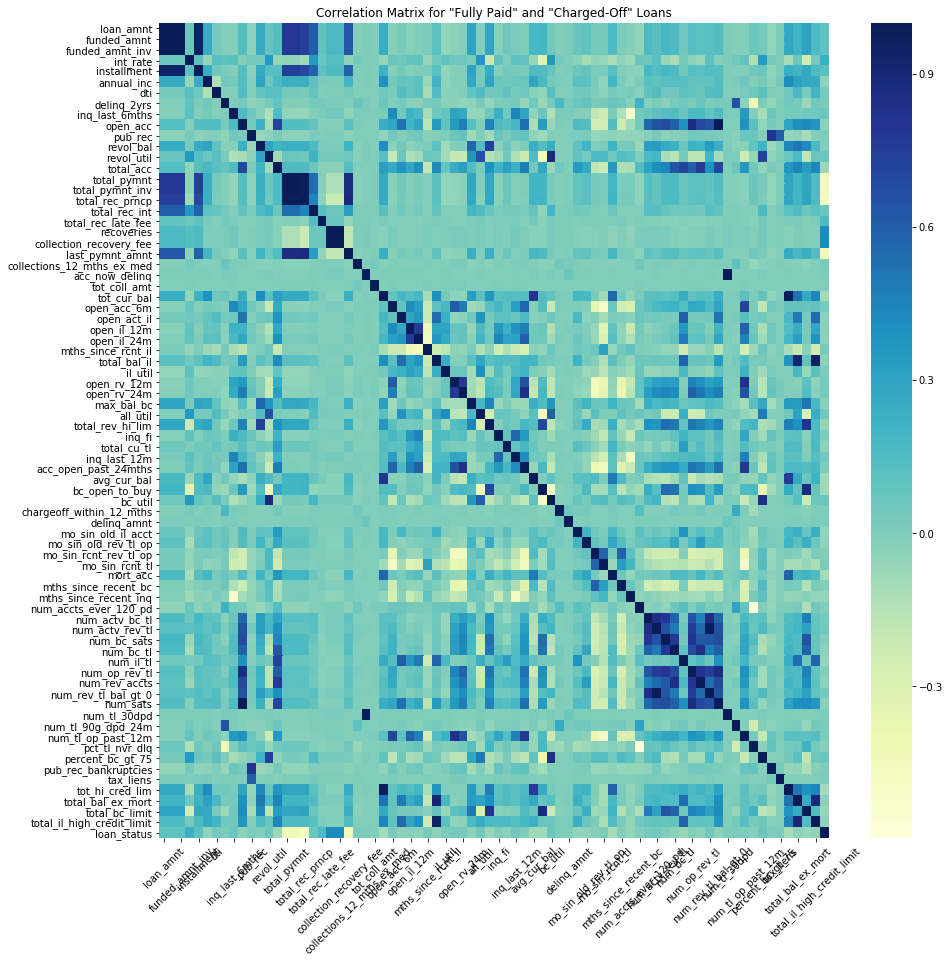

In [193]:
plt.rcParams['figure.figsize']=(15,15)
corr = fp_off_df.corr()
ax = sns.heatmap(corr, annot = False, cmap="YlGnBu")     
plt.setp(ax.axes.get_xticklabels(), rotation=45)

plt.title('Correlation Matrix for "Fully Paid" and "Charged-Off" Loans')

It's much easier to analyze the correlations as a table than a heatmap.

In [194]:
corr

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_status
loan_amnt,1.000000,1.000000,0.999996,0.064321,0.951794,0.259117,0.035443,-0.003557,-0.015973,0.138508,-0.035118,0.260597,0.080490,0.136562,0.784047,0.784081,0.739901,0.596546,0.094262,0.169921,0.169157,0.632733,-0.015568,0.002222,0.000670,0.245549,-0.018599,0.024490,-0.017624,0.001204,0.008215,0.119471,-0.052275,-0.023755,-0.013767,0.300600,-0.000981,0.292125,-0.023324,0.055222,0.016457,0.006934,0.177129,0.192424,0.044151,-0.009230,0.008927,0.072406,0.102070,0.021241,0.025445,0.162763,0.007426,-0.016978,-0.044813,0.162179,0.122096,0.187340,0.167434,0.055414,0.128682,0.118957,0.121298,0.139016,0.002222,-0.012083,-0.015852,0.065922,0.028899,-0.050067,0.008223,0.272100,0.212266,0.307075,0.163192,0.106242
funded_amnt,1.000000,1.000000,0.999996,0.064321,0.951794,0.259117,0.035443,-0.003557,-0.015973,0.138508,-0.035118,0.260597,0.080490,0.136562,0.784047,0.784081,0.739901,0.596546,0.094262,0.169921,0.169157,0.632733,-0.015568,0.002222,0.000670,0.245549,-0.018599,0.024490,-0.017624,0.001204,0.008215,0.119471,-0.052275,-0.023755,-0.013767,0.300600,-0.000981,0.292125,-0.023324,0.055222,0.016457,0.006934,0.177129,0.192424,0.044151,-0.009230,0.008927,0.072406,0.102070,0.021241,0.025445,0.162763,0.007426,-0.016978,-0.044813,0.162179,0.122096,0.187340,0.167434,0.055414,0.128682,0.118957,0.121298,0.139016,0.002222,-0.012083,-0.015852,0.065922,0.028899,-0.050067,0.008223,0.272100,0.212266,0.307075,0.163192,0.106242
funded_amnt_inv,0.999996,0.999996,1.000000,0.064457,0.951731,0.259136,0.035434,-0.003578,-0.015993,0.138489,-0.035165,0.260607,0.080502,0.136542,0.784031,0.784071,0.739876,0.596581,0.094263,0.169976,0.169211,0.632733,-0.015571,0.002225,0.000671,0.245581,-0.018618,0.024498,-0.017622,0.001202,0.008209,0.119492,-0.052260,-0.023791,-0.013815,0.300612,-0.000964,0.292146,-0.023324,0.055225,0.016433,0.006898,0.177163,0.192452,0.044155,-0.009217,0.008931,0.072400,0.102061,0.021263,0.025460,0.162790,0.007438,-0.016957,-0.044842,0.162156,0.122058,0.187326,0.167412,0.055416,0.128650,0.118920,0.121261,0.138997,0.002225,-0.012097,-0.015878,0.065961,0.028914,-0.050117,0.008210,0.272132,0.212288,0.307102,0.163213,0.106269
int_rate,0.064321,0.064321,0.064457,1.000000,0.108849,-0.062454,0.122539,0.103040,0.116027,-0.013009,0.032942,0.031594,0.352118,-0.050980,-0.036575,-0.036458,-0.085549,0.353783,0.070040,0.138457,0.135748,-0.029977,0.033020,0.005581,0.006230,-0.060309,0.077746,0.054061,0.096275,0.094194,-0.055358,0.050599,0.103501,0.056779,0.056825,0.015415,0.359896,-0.202882,0.095354,0.005813,0.108748,0.083737,-0.067203,-0.332786,0.361216,0.029283,0.001688,-0.031543,-0.107592,-0.045039,-0.061256,-0.114189,-0.041412,-0.083969,0.066972,0.055289,0.110173,-0.067816,-0.106850,0.021676,-0.035322,-0.072762,0.106069,-0.013653,0.005581,0.047502,0.089402,-0.124705,0.345065,0.038264,0.004321,-0.108127,0.056472,-0.243375,0.034426,0.235054
installment,0.951794,0.951794,0.951731,0.108849

It's possible to note a significant positive correlation (correlation > 0.1) between a Charge-off loan (loan_status=1) with:
* Loan amount
* Longer loan term
* Installment
* Recoveries and recovery fees, although this is not a predictive feature since these happen on charge-off loans after the fact.
* Debt-to-income of co-borrowers
* Credit inquiries in the last 6 months at time of application for the secondary applicant
* Ratio of total current balance to high credit/credit limit for all revolving accounts 
* Number of collections within last 12 months excluding medical collections at time of application for the secondary applicant
* hardship_dpd

Significant negative correlations (correlation < -0.1) happen with:
* Total payment
* total_rec_prncp
* last_pymnt_amnt
* Total high credit/credit limit
* Number of mortgage accounts at time of application for the secondary applicant
* Months since most recent 90-day or worse rating at time of application for the secondary applicant
* hardship_amount
* orig_projected_additional_accrued_interest
* hardship_payoff_balance_amount
* The lower boundary range the borrower’s FICO at loan origination belongs to.
* The upper boundary range the borrower’s FICO at loan origination belongs to.
* last_fico_range_high
* last_fico_range_low
* FICO range (low) for the secondary applicant
* FICO range (high) for the secondary applicant

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000063CFEB00>,
      dtype=object)

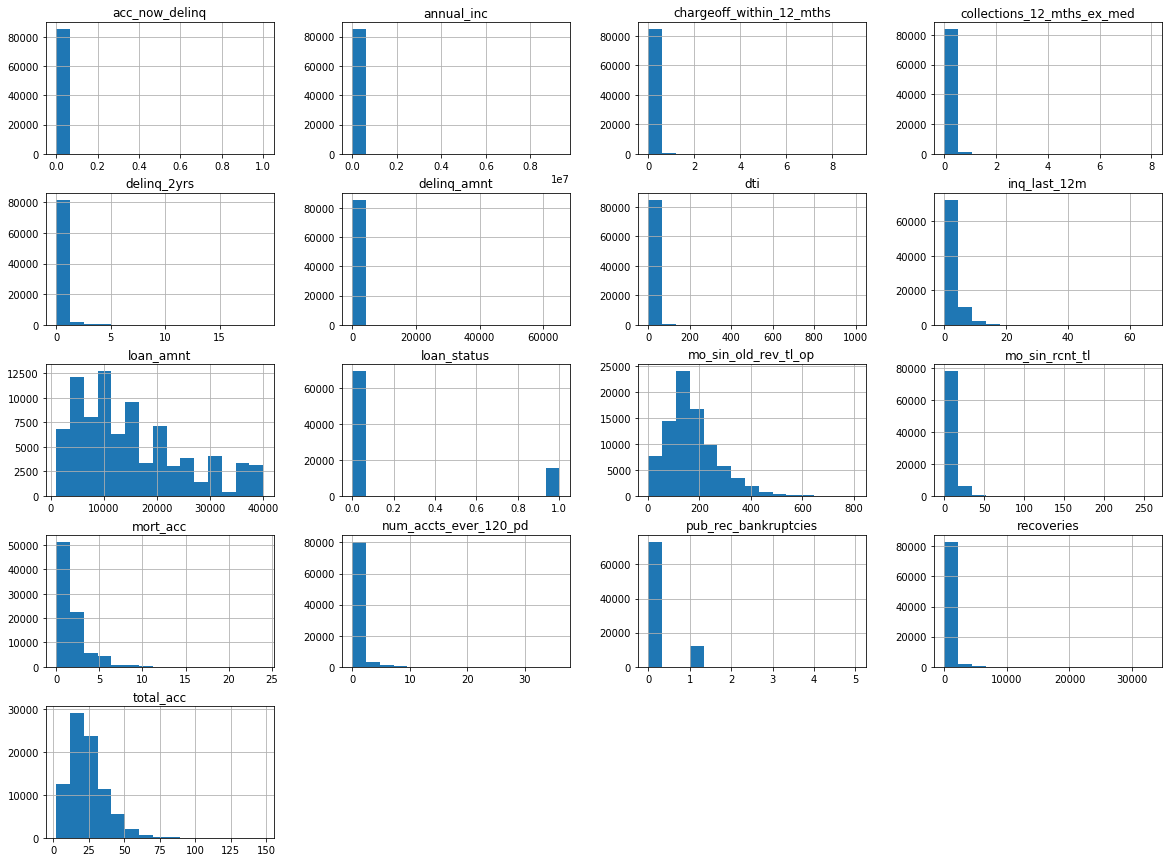

In [137]:
plt.rcParams['figure.figsize']=(20,15)

hist_feat = ['loan_status',
             'annual_inc',
             
             'loan_amnt', 
             
             'recoveries', 
             'chargeoff_within_12_mths', 
             'mort_acc', 
             'pub_rec_bankruptcies',
            'acc_now_delinq',
            'collections_12_mths_ex_med',
            'delinq_2yrs',
            'dti',
            'delinq_amnt',
            'inq_last_12m',
            'mo_sin_old_rev_tl_op',
            'mo_sin_rcnt_tl',
            'num_accts_ever_120_pd',
            'total_acc'
            ]

fp_off_df.hist(column=hist_feat, bins=15)

Categories pictured above appear to respond to a Poisson distribution, or a somewhat skewed normal distribution in some cases. 


It's possible to see that the Loan Status categories are heavily unbalanced, favoring the "Fully Paid" Loans. Later, this unbalanced is rectified with the creation of synthetic samples with the SMOTE algorithm.

#### Features to be dropped:

An important point is to get rid of features that are determined after a loan is either 'fully paid' or 'charged off' to avoid data leaking. For example, in a previous iteration, 'last_pymnt_amnt' came as the most important feature for the Random Forest classifier with a value of approximately 0.49 (when all features sum up to 1.0), showing a data point collected while the loan is being paid off.

* emp_title: too much string variation and information should be highly correlated with income
* title: same information as purpose
* total_rec_prncp: information gathered after loan has been extended
* total_pymnt: information gathered after loan has been extended
* total_pymnt_inv: information gathered after loan has been extended
* total_rec_prncp: information gathered after loan has been extended
* total_rec_int: information gathered after loan has been extended
* total_rec_late_fee: information gathered after loan has been extended
* recoveries: information gathered after loan has been extended
* collection_recovery_fee: information gathered after loan has been extended
* last_pymnt_d: information gathered after loan has been extended
* next_pymnt_d: information gathered after loan has been extended
* last_credit_pull_d: information gathered after loan has been extended
* zip_code: some zip codes could be related with higher income but values would change between states
* last_pymnt_amnt: information gathered after loan has been extended



In [138]:
drop_feat = ['emp_title',
             'title',
             'total_rec_prncp',
             'total_pymnt',
             'total_pymnt_inv',
             'total_rec_prncp',
             'total_rec_int',
             'total_rec_late_fee',
             'recoveries',
             'collection_recovery_fee',
             'last_pymnt_d',
             'zip_code',
             'last_credit_pull_d',
             'last_pymnt_amnt']

fp_off_df.drop(drop_feat, axis=1, inplace=True)

In [140]:
# Credits: https://towardsdatascience.com/financial-data-analysis-bf4b5e78c45c

fp_off_df.purpose =              fp_off_df.purpose.astype("category", categories=np.unique(fp_off_df.purpose)).cat.codes
fp_off_df.home_ownership =       fp_off_df.home_ownership.astype("category", categories = np.unique(fp_off_df.home_ownership)).cat.codes
fp_off_df.grade =                fp_off_df.grade.astype("category", categories = np.unique(fp_off_df.grade)).cat.codes
fp_off_df.sub_grade =            fp_off_df.sub_grade.astype("category", categories = np.unique(fp_off_df.sub_grade)).cat.codes
fp_off_df.addr_state =           fp_off_df.addr_state.astype("category", categories = np.unique(fp_off_df.addr_state)).cat.codes
fp_off_df.term =                 fp_off_df.term.astype("category", categories = np.unique(fp_off_df.term)).cat.codes
fp_off_df.verification_status =  fp_off_df.verification_status.astype("category", categories = np.unique(fp_off_df.verification_status)).cat.codes
fp_off_df.addr_state =           fp_off_df.addr_state.astype("category", categories = np.unique(fp_off_df.addr_state)).cat.codes
fp_off_df.earliest_cr_line =     fp_off_df.earliest_cr_line.astype("category", categories = np.unique(fp_off_df.earliest_cr_line)).cat.codes
fp_off_df.initial_list_status =  fp_off_df.initial_list_status.astype("category", categories = np.unique(fp_off_df.initial_list_status)).cat.codes
fp_off_df.application_type =     fp_off_df.application_type.astype("category", categories = np.unique(fp_off_df.application_type)).cat.codes
fp_off_df.debt_settlement_flag = fp_off_df.debt_settlement_flag.astype("category", categories = np.unique(fp_off_df.debt_settlement_flag)).cat.codes

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  This is separate from the ipykernel package so we can avoid doing imports until
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  after removing the cwd from sys.path.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecat

In [141]:
#map
fp_off_df.emp_length.unique()

array(['4 years', '< 1 year', '3 years', '10+ years', '6 years',
       '2 years', '5 years', '9 years', '8 years', '7 years', '1 year',
       nan], dtype=object)

In [142]:
# This mapping will allow to 

emp_length_mapping = {'< 1 year': 0, 
                      '1 year':   1,
                      '2 years':  2,
                      '3 years':  3,
                      '10+ years':10,
                      '6 years':  6,
                      '4 years':  4, 
                      '5 years':  5, 
                      '9 years':  9,
                      '8 years':  8,
                      '7 years':  7                    
                     }
fp_off_df['emp_length'] = fp_off_df['emp_length'].map(emp_length_mapping)


In [143]:
fp_off_df['emp_length'].fillna(fp_off_df.groupby('loan_status')['emp_length'].transform('median'), inplace=True)
fp_off_df.isnull().values.any()

False

### Data split

In [145]:
fp_off_df['issue_d'] = fp_off_df['issue_d'].map(lambda x: x.rstrip('-2018'))

In [146]:
fp_off_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,debt_settlement_flag,loan_status
11,10000.0,10000.0,10000.0,1,14.07,233.05,2,12,4.0,3,42000.0,1,Mar,5,9,24.69,0.0,570,0.0,17.0,0.0,707.0,15.7,34.0,1,0.0,0,0.0,0.0,93913.0,0.0,15.0,0.0,0.0,54.0,93206.0,116.0,0.0,1.0,707.0,111.0,4500.0,0.0,0.0,0.0,1.0,5524.0,3793.0,15.7,0.0,0.0,161.0,88.0,18.0,18.0,0.0,18.0,18.0,14.0,1.0,1.0,2.0,4.0,30.0,2.0,4.0,1.0,17.0,0.0,0.0,0.0,43.8,0.0,0.0,0.0,84930.0,93913.0,4500.0,80430.0,0,0
16,7000.0,7000.0,7000.0,0,11.98,232.44,1,9,0.0,1,40000.0,2,Mar,3,42,20.25,0.0,418,0.0,13.0,0.0,5004.0,36.0,29.0,1,0.0,0,0.0,0.0,131726.0,1.0,6.0,0.0,2.0,16.0,126722.0,102.0,2.0,2.0,3944.0,90.0,13900.0,2.0,1.0,4.0,4.0,10977.0,4996.0,50.0,0.0,0.0,122.0,132.0,1.0,1.0,0.0,10.0,5.0,3.0,2.0,2.0,3.0,4.0,19.0,7.0,10.0,2.0,13.0,0.0,0.0,2.0,89.7,33.3,0.0,0.0,132817.0,131726.0,10000.0,118917.0,0,0
17,20000.0,20000.0,20000.0,1,26.77,607.97,4,24,3.0,3,33500.0,0,Mar,4,13,24.40,0.0,96,1.0,27.0,0.0,7364.0,46.0,34.0,1,0.0,0,0.0,308.0,160804.0,0.0,21.0,0.0,0.0,29.0,153440.0,118.0,0.0,2.0,2607.0,110.0,16000.0,0.0,0.0,2.0,2.0,5956.0,2767.0,68.6,0.0,0.0,115.0,115.0,20.0,20.0,0.0,26.0,5.0,0.0,3.0,6.0,3.0,3.0,27.0,6.0,7.0,6.0,27.0,0.0,0.0,0.0,100.0,33.3,0.0,0.0,146514.0,160804.0,8800.0,130514.0,0,1
20,21000.0,21000.0,21000.0,1,20.39,560.94,3,18,10.0,2,85000.0,1,Mar,4,33,15.76,1.0,521,0.0,15.0,0.0,14591.0,34.2,27.0,1,0.0,0,0.0,0.0,128270.0,1.0,1.0,2.0,2.0,7.0,37076.0,74.0,2.0,5.0,5354.0,34.0,42700.0,6.0,4.0,13.0,8.0,8551.0,16684.0,38.4,0.0,0.0,67.0,112.0,4.0,4.0,3.0,4.0,0.0,0.0,5.0,7.0,6.0,10.0,3.0,12.0,21.0,7.0,15.0,0.0,0.0,4.0,92.6,16.7,0.0,0.0,172433.0,51667.0,27100.0,39733.0,0,0
23,30000.0,30000.0,30000.0,0,7.34,930.99,0,3,3.0,2,95000.0,2,Mar,4,42,16.18,1.0,575,0.0,10.0,0.0,755.0,0.0,20.0,1,0.0,0,0.0,2157.0,12704.0,0.0,1.0,0.0,1.0,22.0,10747.0,74.0,0.0,2.0,741.0,3.0,101800.0,1.0,3.0,0.0,3.0,1412.0,90245.0,0.0,0.0,0.0,101.0,98.0,13.0,13.0,0.0,19.0,24.0,0.0,2.0,2.0,4.0,6.0,5.0,8.0,13.0,2.0,10.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,163978.0,12704.0,91000.0,40690.0,0,0


In [147]:
issue_d_mapping = {'Jan': 1,
                   'Feb': 2,                     
                   'Mar': 3,                     
                   'Apr': 4,                     
                   'May': 5,                     
                   'Jun': 6,                    
                   'Jul': 7,                     
                   'Aug': 8, 
                   'Sep': 9,
                   'Oct': 10,                     
                   'Nov': 11,
                   'Dec': 12
                  }
fp_off_df['issue_d'] = fp_off_df['issue_d'].map(issue_d_mapping)

In [148]:
# eliminating outliers
fp_off_df = fp_off_df[(np.abs(stats.zscore(fp_off_df)) < 3).all(axis=1)] # from stack overflow

fp_off_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50761 entries, 16 to 128407
Data columns (total 81 columns):
loan_amnt                     50761 non-null float64
funded_amnt                   50761 non-null float64
funded_amnt_inv               50761 non-null float64
term                          50761 non-null int8
int_rate                      50761 non-null float64
installment                   50761 non-null float64
grade                         50761 non-null int8
sub_grade                     50761 non-null int8
emp_length                    50761 non-null float64
home_ownership                50761 non-null int8
annual_inc                    50761 non-null float64
verification_status           50761 non-null int8
issue_d                       50761 non-null int64
purpose                       50761 non-null int8
addr_state                    50761 non-null int8
dti                           50761 non-null float64
delinq_2yrs                   50761 non-null float64
earliest_cr

In [149]:
train_mths = [1, 2, 3, 4, 5, 6, 7, 8, 9]
test_mths  = [10, 11, 12]

train_df = fp_off_df[fp_off_df['issue_d'].isin(train_mths)]

test_df =  fp_off_df[fp_off_df['issue_d'].isin(test_mths)]

In [150]:
train_df.sample(10)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,debt_settlement_flag,loan_status
105525,5000.0,5000.0,5000.0,0,6.67,153.64,0,1,10.0,2,65000.0,0,7,2,34,16.86,0.0,462,0.0,9.0,0.0,9180.0,33.0,35.0,1,0.0,1,0.0,0.0,57077.0,0.0,1.0,0.0,1.0,14.0,47897.0,74.0,0.0,1.0,848.0,33.0,27800.0,0.0,1.0,0.0,2.0,6342.0,652.0,56.5,0.0,0.0,154.0,218.0,18.0,14.0,1.0,39.0,5.0,0.0,1.0,6.0,1.0,2.0,22.0,8.0,12.0,6.0,9.0,0.0,0.0,0.0,96.8,0.0,0.0,0.0,80128.0,57077.0,1500.0,52328.0,0,0
49777,15600.0,15600.0,15600.0,0,17.97,563.75,3,15,3.0,3,88500.0,2,8,1,14,12.79,0.0,153,0.0,8.0,0.0,12940.0,98.8,10.0,1,0.0,0,0.0,0.0,20706.0,0.0,2.0,0.0,1.0,19.0,7766.0,49.0,0.0,0.0,3808.0,71.0,13100.0,1.0,2.0,0.0,1.0,2958.0,144.0,98.2,0.0,0.0,68.0,80.0,45.0,19.0,0.0,45.0,19.0,0.0,4.0,5.0,4.0,5.0,3.0,6.0,7.0,5.0,8.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,29100.0,20706.0,8100.0,16000.0,0,0
129042,5000.0,5000.0,5000.0,0,10.41,162.31,1,7,5.0,2,10488.0,0,4,1,15,38.79,0.0,374,0.0,7.0,0.0,4430.0,23.0,11.0,1,0.0,0,0.0,0.0,6416.0,0.0,1.0,0.0,0.0,27.0,1986.0,31.0,0.0,0.0,1411.0,25.0,19300.0,0.0,0.0,1.0,0.0,917.0,14870.0,23.0,0.0,0.0,27.0,69.0,29.0,27.0,0.0,29.0,8.0,0.0,4.0,4.0,6.0,9.0,1.0,6.0,10.0,4.0,7.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,25700.0,6416.0,19300.0,6400.0,0,1
5433,25000.0,25000.0,25000.0,1,22.90,703.33,4,20,6.0,2,52000.0,0,6,5,39,8.95,0.0,624,1.0,16.0,0.0,3476.0,14.0,24.0,1,0.0,0,0.0,629.0,26715.0,1.0,11.0,0.0,0.0,58.0,23239.0,85.0,1.0,2.0,2216.0,51.0,24800.0,0.0,0.0,1.0,2.0,1670.0,19084.0,15.2,0.0,0.0,104.0,129.0,3.0,3.0,0.0,3.0,3.0,0.0,2.0,3.0,4.0,4.0,16.0,5.0,8.0,3.0,16.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,52281.0,26715.0,22500.0,27481.0,0,0
123086,7500.0,7500.0,7500.0,0,9.43,240.01,1,5,2.0,3,80000.0,0,4,2,44,23.39,0.0,571,1.0,6.0,0.0,4535.0,28.0,13.0,1,0.0,0,0.0,0.0,83626.0,0.0,2.0,0.0,2.0,16.0,79091.0,74.0,3.0,4.0,3816.0,28.0,16200.0,1.0,2.0,1.0,6.0,13938.0,9665.0,31.9,0.0,0.0,150.0,20.0,9.0,9.0,0.0,9.0,1.0,0.0,2.0,2.0,3.0,3.0,9.0,4.0,4.0,2.0,6.0,0.0,0.0,3.0,91.7,0.0,0.0,0.0,107506.0,83626.0,14200.0,91306.0,0,1
66596,3800.0,3800.0,3800.0,0,11.99,126.20,1,9,6.0,1,36097.0,1,2,6,32,16.76,0.0,413,0.0,6.0,1.0,2818.0,19.8,21.0,0,0.0,0,0.0,0.0,221756.0,2.0,1.0,2.0,3.0,6.0,23130.0,94.0,1.0,2.0,2632.0,67.0,14200.0,1.0,0.0,3.0,7.0,44351.0,7368.0,26.3,0.0,0.0,97.0,190.0,11.0,6.0,5.0,24.0,6.0,0.0,1.0,2.0,1.0,4.0,6.0,4.0,10.0,2.0,6.0,0.0,0.0,4.0,100.0,0.0,1.0,0.0,236148.0,25948.0,10000.0,24645.0,0,0
88724,2500.0,2500.0,2500.0,0,9.44,80.02,1,5,10.0,1,30000.0,2,1,1,44,6.13,0.0,91,2.0,10.0,0.0,3561.0,13.8,16.0,1,0.0,0,0.0,1323.0,171440.0,3.0,0.0,0.0,0.0,79.0,0.0,74.0,5.0,7.0,1670.0,14.0,25800.0,0.0,0.0,4.0,8.0,17144.0,16774.0,17.0,0.0,0.0,173.0,140.0,6.0,2.0,1.0,7.0,4.0,0.0,5.0,7.0,6.0,9.0,2.0,9.0,13.0,7.0,10.0,0.0,0.0,6.0,93.8,0.0,0.0,0.0,193992.0,3561.0,20200.0,0.0,0,0
70387,4200.0,4200.0,4200.0,0,11.99,139.49,1,9,7.0,3,47860.0,1,2,8,46,13.11,0.0,144,1.0,6.0,1.0,965.0,14.2,22.0,0,0.0,0,0.0,294.0,20202.0,1.0,1.0,1.0,2.0,7.0,19237.0,73.0,3.0,5.0,112.0,61.0,6800.0,2

In [151]:
test_df.sample(10)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,debt_settlement_flag,loan_status
69369,10000.0,10000.0,10000.0,1,10.72,216.04,1,6,10.0,2,90000.0,1,11,6,5,3.72,0.0,571,1.0,10.0,0.0,656.0,2.7,39.0,0,0.0,0,0.0,0.0,267731.0,0.0,2.0,1.0,5.0,9.0,12845.0,86.0,0.0,2.0,655.0,35.0,24000.0,1.0,2.0,2.0,8.0,26773.0,21045.0,3.0,0.0,0.0,131.0,157.0,17.0,9.0,6.0,17.0,1.0,0.0,1.0,2.0,4.0,11.0,10.0,7.0,23.0,2.0,10.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,300923.0,13501.0,21700.0,14923.0,0,0
111658,12000.0,12000.0,12000.0,1,12.73,271.39,1,9,8.0,3,181000.0,1,10,1,4,10.02,0.0,570,0.0,10.0,0.0,15617.0,45.5,27.0,1,0.0,0,0.0,0.0,67865.0,0.0,5.0,0.0,0.0,32.0,52248.0,73.0,0.0,1.0,3755.0,60.0,34300.0,0.0,6.0,0.0,1.0,6787.0,8545.0,30.5,0.0,0.0,168.0,94.0,21.0,21.0,0.0,48.0,5.0,0.0,1.0,4.0,2.0,2.0,19.0,5.0,8.0,4.0,10.0,0.0,0.0,0.0,88.9,0.0,0.0,0.0,110928.0,67865.0,12300.0,76628.0,0,0
54138,6500.0,6500.0,6500.0,0,8.19,204.26,0,3,5.0,3,65000.0,0,11,2,23,3.79,1.0,36,0.0,14.0,0.0,4199.0,18.9,31.0,1,0.0,0,0.0,0.0,4199.0,0.0,0.0,1.0,1.0,11.0,0.0,74.0,0.0,0.0,1108.0,19.0,22200.0,1.0,0.0,1.0,1.0,300.0,9029.0,28.9,0.0,0.0,79.0,181.0,30.0,11.0,4.0,34.0,11.0,1.0,6.0,8.0,10.0,13.0,9.0,14.0,18.0,8.0,14.0,0.0,1.0,1.0,96.6,0.0,0.0,0.0,22200.0,4199.0,12700.0,0.0,0,1
56382,11000.0,11000.0,11000.0,0,14.47,378.47,2,11,10.0,3,80000.0,0,11,2,9,6.38,0.0,572,0.0,8.0,0.0,7203.0,94.8,10.0,1,0.0,0,0.0,0.0,13087.0,0.0,3.0,0.0,1.0,18.0,5884.0,74.0,0.0,0.0,2246.0,84.0,7600.0,0.0,0.0,0.0,1.0,1636.0,397.0,94.8,0.0,0.0,145.0,34.0,25.0,18.0,0.0,25.0,18.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,8.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,15605.0,13087.0,7600.0,8005.0,0,0
112906,1000.0,1000.0,1000.0,0,23.40,38.92,4,20,3.0,1,46500.0,0,10,2,21,18.04,0.0,99,1.0,6.0,0.0,1353.0,84.6,7.0,0,0.0,0,0.0,0.0,202326.0,1.0,3.0,0.0,0.0,28.0,48781.0,38.0,1.0,1.0,900.0,42.0,1600.0,4.0,0.0,6.0,2.0,33721.0,247.0,84.6,0.0,0.0,86.0,50.0,10.0,2.0,1.0,10.0,4.0,0.0,2.0,2.0,2.0,2.0,3.0,2.0,3.0,2.0,6.0,0.0,0.0,2.0,100.0,100.0,0.0,0.0,212025.0,50134.0,1600.0,58233.0,0,0
57614,2500.0,2500.0,2500.0,0,16.14,88.07,2,13,3.0,2,45000.0,0,11,8,5,26.85,0.0,345,0.0,8.0,1.0,8608.0,96.7,12.0,0,0.0,0,0.0,0.0,20201.0,0.0,3.0,1.0,3.0,12.0,11593.0,63.0,0.0,0.0,2390.0,74.0,8900.0,0.0,1.0,0.0,3.0,2525.0,233.0,96.4,0.0,0.0,42.0,425.0,35.0,12.0,0.0,59.0,5.0,0.0,4.0,5.0,4.0,6.0,4.0,5.0,8.0,5.0,8.0,0.0,0.0,1.0,91.7,100.0,1.0,0.0,27400.0,20201.0,6400.0,18500.0,0,0
99279,5000.0,5000.0,5000.0,0,6.67,153.64,0,1,10.0,1,66000.0,0,10,1,13,9.49,0.0,448,0.0,7.0,0.0,1234.0,5.7,37.0,1,0.0,0,0.0,0.0,202808.0,0.0,2.0,1.0,2.0,7.0,17073.0,65.0,0.0,0.0,1234.0,38.0,21500.0,2.0,8.0,3.0,2.0,28973.0,15766.0,7.3,0.0,0.0,149.0,389.0,29.0,7.0,2.0,29.0,7.0,1.0,1.0,1.0,3.0,8.0,19.0,4.0,16.0,1.0,7.0,0.0,0.0,1.0,86.5,0.0,0.0,0.0,241239.0,18307.0,17000.0,26414.0,0,0
115042,17000.0,17000.0,17000.0,0,8.46,536.34,0,4,0.0,1,102000.0,0,10,2,33,8.24,0.0,564,2.0,12.0,1.0,10513.0,18.4,23.0,1,0.0,0,0.0,0.0,27394.0,0.0,2.0,1.0,2.0,11.0,16881.0,50.0,1.0,1.0,4731.0

In [152]:
# transfer new data into new X and y arrays for the training set

X_train = np.array(train_df.iloc[:, :-1].values)
y_train = np.array(train_df.iloc[:,  -1].values) # class label is contained here

np.mean(y_train), np.std(y_train), np.var(y_train)  

(0.17774318715033388, 0.3822964119266296, 0.14615054657197526)

In [153]:
# transfer new data into new X and y arrays for the test set

X_test = np.array(test_df.iloc[:, :-1].values)
y_test = np.array(test_df.iloc[:,  -1].values) # class label is contained here

np.mean(y_test), np.std(y_test), np.var(y_test)  

(0.08767293642157625, 0.282818656811736, 0.0799863926407945)

In [154]:
### Oversampling the minority class of the training set with SMOTE

print('Original dataset shape %s' % Counter(y_train))

smote = SMOTE(sampling_strategy ='minority', random_state = 1)
              
X_res, y_res = smote.fit_resample(X_train, y_train)
              
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 36449, 1: 7879})
Resampled dataset shape Counter({0: 36449, 1: 36449})


In [155]:
# Scaling data

stdsc = StandardScaler()

X_train = stdsc.fit_transform(X_res)
X_test = stdsc.transform(X_test)
y_train = y_res

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(72898, 80)
(72898,)
(6433, 80)
(6433,)


### Early classification results with a base Random Forest Classifier

In [156]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_jobs=-1)
rnd_clf.fit(X_train, y_train)

c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [157]:
# Identification of the most important features for a RF
sorted(zip(rnd_clf.feature_importances_, train_df.columns), reverse=True)

[(0.08886812653909426, 'grade'),
 (0.049102040542265926, 'verification_status'),
 (0.04741828949621948, 'sub_grade'),
 (0.047089689529095924, 'term'),
 (0.03788574691115753, 'inq_last_6mths'),
 (0.03776713874427612, 'int_rate'),
 (0.03436621940035981, 'open_acc_6m'),
 (0.02468525353618723, 'purpose'),
 (0.024159643465604973, 'emp_length'),
 (0.020189490710149423, 'open_rv_24m'),
 (0.020016935822132494, 'issue_d'),
 (0.01924614911138346, 'open_rv_12m'),
 (0.0182915082221681, 'home_ownership'),
 (0.017336479881879995, 'mo_sin_rcnt_tl'),
 (0.013303820744322833, 'mths_since_recent_inq'),
 (0.013124572558795922, 'open_il_12m'),
 (0.012866850258275586, 'mo_sin_rcnt_rev_tl_op'),
 (0.01185626729341289, 'loan_amnt'),
 (0.01176572321273736, 'tot_hi_cred_lim'),
 (0.011522981114579767, 'inq_last_12m'),
 (0.011489677648285911, 'mort_acc'),
 (0.011395533758251081, 'installment'),
 (0.011339194743364572, 'pub_rec'),
 (0.01133747488227348, 'num_tl_op_past_12m'),
 (0.011118707031912856, 'avg_cur_bal'),

In [158]:
def testing_metrics(clf, X_test, y_test, prediction):
    
    # testing metrics
    print("Evaluation parameters on testing data:")
    print("\n")

    print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, prediction)))
    print("AUC: {0:.4f}".format(metrics.roc_auc_score(y_test, prediction)))
    print("Precision: {0:.4f}".format(metrics.precision_score(y_test, prediction)))
    print("Recall: {0:.4f}".format(metrics.recall_score(y_test, prediction)))
    print("F1: {0:.4f}".format(metrics.f1_score(y_test, prediction)))

    print("\n")
    print("Confusion Matrix")
    print(confusion_matrix(y_test, prediction))

    tr_probas = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, tr_probas[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    current_auc = str('%.2f' %roc_auc)
    fig = plt.figure(figsize=(5, 5))    
    plt.plot(fpr, tpr, lw=1, label= str('Classifier on testing data' + ' AUC: ' + current_auc))

    plt.plot([0, 1], 
             [0, 1], 
             linestyle='--', 
             color=(0.6, 0.6, 0.6), 
             label='random guessing')

    plt.plot([0, 0, 1], 
             [0, 1, 1], 
             lw=2, 
             linestyle=':', 
             color='black', 
             label='perfect performance')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('Receiver Operator Characteristic')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


Evaluation parameters on testing data:


Accuracy: 0.8913
AUC: 0.5181
Precision: 0.1770
Recall: 0.0656
F1: 0.0957


Confusion Matrix
[[5697  172]
 [ 527   37]]


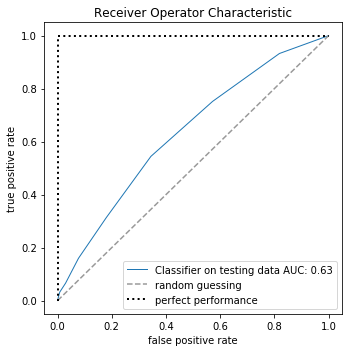

In [159]:
rfc_pred = rnd_clf.predict(X_test)

testing_metrics(rnd_clf, X_test, y_test, rfc_pred)

c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:2

c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:2

c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:2

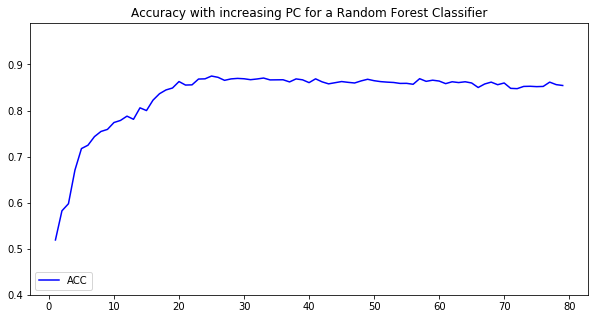

In [160]:
def plotvector(X_train, y_train, X_test, y_test):
    results = []
    
    for i in range(1, 80):
        pipe_rfc = Pipeline([('pca', PCA(n_components=i, random_state=1)),
                     ('clf', RandomForestClassifier(n_jobs=-1, random_state=1))])
        
        pipe_rfc.fit(X_train, y_train)
        results.append([i, pipe_rfc.score(X_test, y_test)])
 
    return np.array(results)

PCA_accuracy =  plotvector(X_train, y_train, X_test, y_test)

plt.rcParams['figure.figsize']=(10,5)
plt.plot(PCA_accuracy[:,0], PCA_accuracy[:,1], color='b', label='ACC')
plt.legend(loc=3)
plt.ylim(0.4, 0.99)
plt.title("Accuracy with increasing PC for a Random Forest Classifier")
plt.show()

Principal component analysis gives the best accuracy score with 25 principal components. We'll apply this number of PCs in subsequent fittings.

For choosing an algorithm, we'll run a few classifiers and sort them according to its base accuracy results. After that, we'll do a RandomizedSearchCV for hyperparameter optimization.

In [56]:
# Let's see how different classifiers do with this dataset

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

#Machine Learning Algorithm (MLA) Selection and Initialization

MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier(),  

    #Gaussian Processes
    #gaussian_process.GaussianProcessClassifier(), # memory error for loan dataset
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
         
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    #SVM
    #svm.SVC(probability=True) # machine frozes
    #svm.NuSVC(probability=True), # over 4 hours of training. Not enough time to fit again for loan dataset.
    #svm.LinearSVC(), # better for 10,000s of datapoints. over 6 hours of training. Not enough time to fit again for loan dataset.
      
    ]

#create table to compare MLA predictions
MLA_predict = fp_off_df['loan_status']

In [57]:
cv_split = 3 # simple cross-validation to save time. The higher the better

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    print(MLA_name)
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    pipe_alg = Pipeline([('pca', PCA(n_components=25)),
                         ('clf', alg)])
    
    cv_results = model_selection.cross_validate(pipe_alg, X_train, y_train, cv=cv_split, n_jobs=-1, verbose=3, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()  
    
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions 
    pipe_alg.fit(X_train, y_train)
    MLA_predict[MLA_name] = pipe_alg.predict(X_test)
    gc.collect()
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

AdaBoostClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   43.4s finished


BaggingClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


ExtraTreesClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.9s finished
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GradientBoostingClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


RandomForestClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.2s finished
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


XGBClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   50.9s finished


LogisticRegressionCV


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.5s finished
c:\program files\python36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


PassiveAggressiveClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished


RidgeClassifierCV


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s finished


SGDClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.2s finished


Perceptron


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s finished


BernoulliNB


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s finished


GaussianNB


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s finished


KNeighborsClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 11.8min finished


DecisionTreeClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.7s finished


ExtraTreeClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished


LinearDiscriminantAnalysis


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s finished


QuadraticDiscriminantAnalysis


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.1s finished


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",1,0.798185,0.121853,9.31153
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.98799,0.770818,0.16425,18.7344
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.98729,0.767402,0.160725,60.6328
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.824735,0.729925,0.0973655,9.21953
14,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.974046,0.69932,0.112921,13.5506
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.757463,0.682681,0.191854,86.5786
5,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.757147,0.682379,0.202522,47.5421
15,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.979067,0.678935,0.060443,4.4293
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.733731,0.676783,0.20784,36.5621
12,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",0.684409,0.648839,0.214681,5.2693


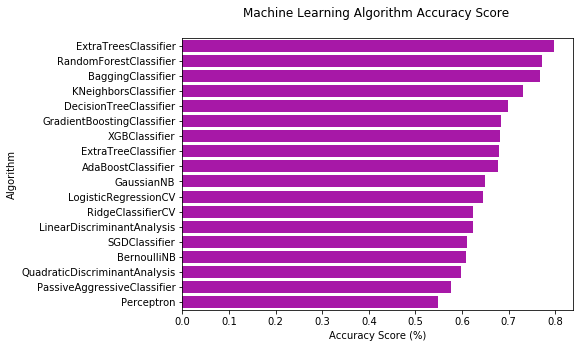

In [65]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')
plt.rcParams['figure.figsize']=(7,5)

In [72]:
pca = PCA(n_components=25, random_state = 1)

pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [95]:
# Let's take the best base classifier and run RandomizedSearchCV

etc = ensemble.ExtraTreesClassifier(random_state=1)
etc

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=1, verbose=0,
                     warm_start=False)

c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Evaluation parameters on testing data:


Accuracy: 0.8820
AUC: 0.5467
Precision: 0.2238
Recall: 0.1401
F1: 0.1723


Confusion Matrix
[[5595  274]
 [ 485   79]]


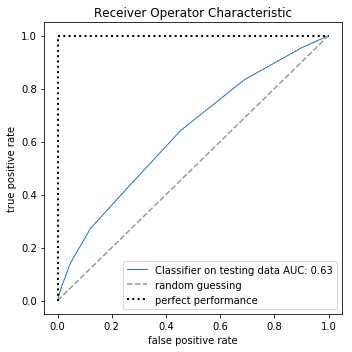

In [96]:
etc.fit(X_train, y_train)
etc_pred = etc.predict(X_test)

testing_metrics(etc, X_test, y_test, etc_pred)

In [102]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

import random

tuned_parameters = { #'loss': ['deviance', 'exponential'],
                     #'learning_rate':  uniform.rvs(loc=0, scale = 1, size=50),
                     'n_estimators': [100, 200, 500, 1000, 2000], 
                     #'subsample' : uniform.rvs(loc=0, scale = 1, size=50),
                     'criterion': ['gini', 'entropy'], 
                     'min_samples_split' : sp_randint(2, 5),
                     'min_samples_leaf' :  sp_randint(1, 5),
                     #'min_weight_leaf' : uniform.rvs(loc=0, scale = 0.5, size=50),
                     'max_depth' : [None],
                     #'min_impurity_decrease' : uniform.rvs(loc=0, scale = 10, size=50),
                     'max_features': ['auto'],#[25],#
                     'max_leaf_nodes' : [None],
                     'bootstrap' : [False],
                     'oob_score' : [False],# turn to false
                     'warm_start' : [False],
                     'random_state': [1]}

# run randomized search

n_iter_search = 10
random_search = RandomizedSearchCV(ensemble.ExtraTreesClassifier(), 
                                   param_distributions=tuned_parameters,
                                   n_iter=n_iter_search, 
                                   cv=3,
                                   n_jobs = -1,
                                   verbose = 3,
                                   iid=False)

random_search = random_search.fit(X_train, y_train)

print('--> Tuned Parameters Best Score: ',random_search.best_score_)
print('--> Best Parameters: \n',random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 106.4min finished


--> Tuned Parameters Best Score:  0.805577360711269
--> Best Parameters: 
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200, 'oob_score': False, 'random_state': 1, 'warm_start': False}


Evaluation parameters on testing data:


Accuracy: 0.9036
AUC: 0.5233
Precision: 0.2778
Recall: 0.0621
F1: 0.1014


Confusion Matrix
[[5778   91]
 [ 529   35]]


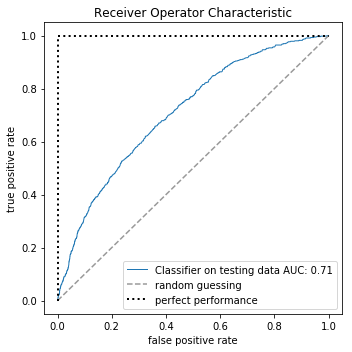

In [103]:
opt_etc = random_search.best_estimator_

opt_etc.fit(X_train, y_train)  

opt_etc_prediction = opt_etc.predict(X_test)

testing_metrics(opt_etc, X_test, y_test, opt_etc_prediction)

This result is already giving a better accuracy (0.9036), and better results would be obtained exploring a wider range of hyperparameter values with a bigger number of iterations and cross-validations in the RandomizedSearchCV, but this would require a bigger computational and time budget. This should aim to not only improve accuracy but to also obtain better results in the Confusion Matrix, which shows large numbers of False Positives and Negatives, and the other evaluation criteria such as Precision, Recall and F1-score. 

Another possibility to achieve better results is to incorporate some of the outlier data, since some of them could contain valuable information for a classification algorithm, and try other approaches to feature engineering.